In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import typing

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict

/usr/local/anaconda3/envs/pitch-sequencing/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
raw_df = pd.read_csv('../../data/raw_data_curmap.csv')

In [5]:
raw_df.head(20)

,game_date,pitch_number,batter,pitcher,pitch_type,events,at_bat_number,zone,outs_when_up,p_throws,stand,type,bb_type,balls,strikes,player_name,on_3b,on_2b,on_1b
0,2017-04-02,1,656941,593372,FF,NaN,1,12.0,0,R,L,B,NaN,0,0,"Martinez, Carlos",NaN,NaN,NaN
1,2017-04-02,4,592450,643493,FF,fielders_choice,75,5.0,0,R,R,X,ground_ball,2,1,"Pruitt, Austin",NaN,NaN,452104.0
2,2017-04-02,1,543305,643493,CB,NaN,76,9.0,0,R,L,S,NaN,0,0,"Pruitt, Austin",NaN,452104.0,592450.0
3,2017-04-02,2,543305,643493,CH,NaN,76,14.0,0,R,L,B,NaN,0,1,"Pruitt, Austin",NaN,452104.0,592450.0
4,2017-04-02,3,543305,643493,SI,NaN,76,13.0,0,R,L,B,NaN,1,1,"Pruitt, Austin",NaN,452104.0,592450.0
5,2017-04-02,4,543305,643493,SI,single,76,4.0,0,R,L,X,line_drive,2,1,"Pruitt, Austin",NaN,452104.0,592450.0
6,2017-04-02,1,474892,517008,FC,NaN,77,7.0,0,R,R,S,NaN,0,0,"Colomé, Alex",452104.0,592450.0,543305.0
7,2017-04-02,2,474892,517008,FC,NaN,77,13.0,0,R,R,B,NaN,0,1,"Colomé, Alex",452104.0,592450.0,543305.0
8,2017-04-02,3,474892,517008,FC,NaN,77,14.0,0,R,R,S,NaN,1,1,"Colomé, Alex",452104.0,592450.0,543305.0
9,2017-04-02,4,474892,517008,FC,NaN,77,14.0,0,R,R,B,NaN,1,2,"Colomé, Alex",452104.0,592450.0,543305.0


In [6]:
raw_df['combined_count'] = raw_df['balls'].astype(str) + "-" + raw_df['strikes'].astype(str)

In [7]:
raw_df.head(10)

,game_date,pitch_number,batter,pitcher,pitch_type,events,at_bat_number,zone,outs_when_up,p_throws,stand,type,bb_type,balls,strikes,player_name,on_3b,on_2b,on_1b,combined_count
0,2017-04-02,1,656941,593372,FF,NaN,1,12.0,0,R,L,B,NaN,0,0,"Martinez, Carlos",NaN,NaN,NaN,0-0
1,2017-04-02,4,592450,643493,FF,fielders_choice,75,5.0,0,R,R,X,ground_ball,2,1,"Pruitt, Austin",NaN,NaN,452104.0,2-1
2,2017-04-02,1,543305,643493,CB,NaN,76,9.0,0,R,L,S,NaN,0,0,"Pruitt, Austin",NaN,452104.0,592450.0,0-0
3,2017-04-02,2,543305,643493,CH,NaN,76,14.0,0,R,L,B,NaN,0,1,"Pruitt, Austin",NaN,452104.0,592450.0,0-1
4,2017-04-02,3,543305,643493,SI,NaN,76,13.0,0,R,L,B,NaN,1,1,"Pruitt, Austin",NaN,452104.0,592450.0,1-1
5,2017-04-02,4,543305,643493,SI,single,76,4.0,0,R,L,X,line_drive,2,1,"Pruitt, Austin",NaN,452104.0,592450.0,2-1
6,2017-04-02,1,474892,517008,FC,NaN,77,7.0,0,R,R,S,NaN,0,0,"Colomé, Alex",452104.0,592450.0,543305.0,0-0
7,2017-04-02,2,474892,517008,FC,NaN,77,13.0,0,R,R,B,NaN,0,1,"Colomé, Alex",452104.0,592450.0,543305.0,0-1
8,2017-04-02,3,474892,517008,FC,NaN,77,14.0,0,R,R,S,NaN,1,1,"Colomé, Alex",452104.0,592450.0,543305.0,1-1
9,2017-04-02,4,474892,517008,FC,NaN,77,14.0,0,R,R,B,NaN,1,2,"Colomé, Alex",452104.0,592450.0,543305.0,1-2


In [8]:
raw_df['events'].value_counts()

events
field_out                    491520
strikeout                    282947
single                       176099
walk                         102277
double                        55701
home_run                      40389
force_out                     24691
grounded_into_double_play     23523
hit_by_pitch                  13762
field_error                    8647
sac_fly                        7941
triple                         5028
sac_bunt                       4373
double_play                    2783
fielders_choice                2591
fielders_choice_out            2027
truncated_pa                   1893
strikeout_double_play           902
catcher_interf                  367
sac_fly_double_play             115
triple_play                      27
sac_bunt_double_play              7
game_advisory                     2
Name: count, dtype: int64

In [9]:
count_state_df = raw_df.groupby(['combined_count', 'pitch_type']).size().reset_index(name='frequency')

In [10]:
count_state_df

,combined_count,pitch_type,frequency
0,0-0,CB,147223
1,0-0,CH,86816
2,0-0,FC,79886
3,0-0,FF,438067
4,0-0,FS,11105
...,...,...,...
118,4-1,SL,1
119,4-2,CH,2
120,4-2,FF,11
121,4-2,SI,6


In [12]:
# Remove values that I'm not sure why are there
count_state_df = count_state_df[count_state_df['combined_count'] != '4-2']
count_state_df = count_state_df[count_state_df['combined_count'] != '4-1']
count_state_df = count_state_df[count_state_df['combined_count'] != '1-3']

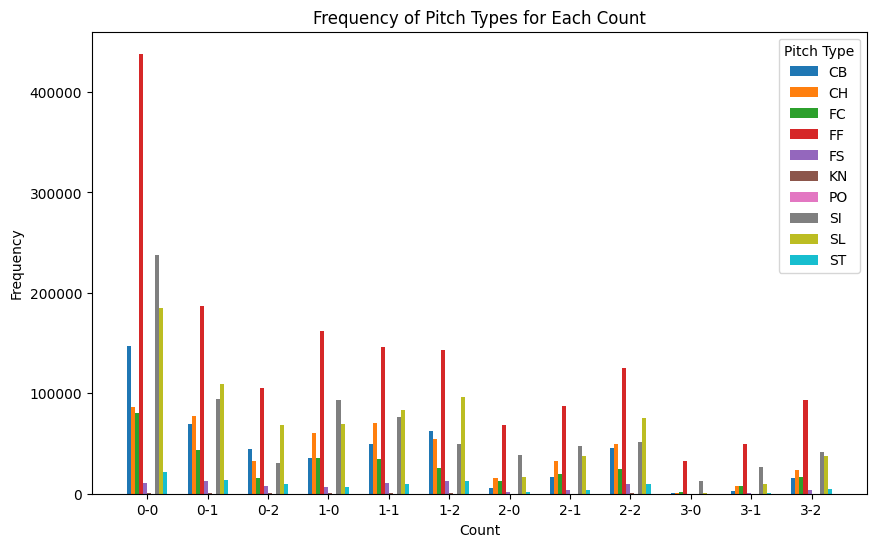

In [13]:
import matplotlib.pyplot as plt

# Create a pivot table for easier plotting
pivot_df = count_state_df.pivot(index='combined_count', columns='pitch_type', values='frequency').fillna(0)

# Get unique pitch types and counts for plotting
pitch_types = pivot_df.columns.tolist()
counts = pivot_df.index.tolist()

# Number of pitch types
n_types = len(pitch_types)

# Position of bars on x-axis
ind = np.arange(len(counts))*1.5

# Width of each bar
width = 0.1

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, pitch_type in enumerate(pitch_types):
    ax.bar(ind + i * width, pivot_df[pitch_type], width, label=pitch_type)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Pitch Types for Each Count')
ax.set_xticks(ind + width * (n_types - 1) / 2)
ax.set_xticklabels(counts)
ax.legend(title='Pitch Type')

plt.show()

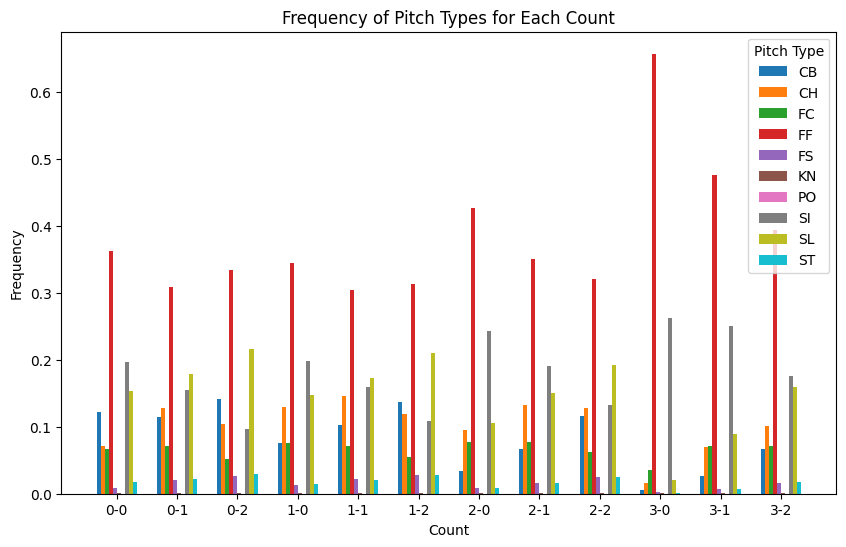

In [14]:
normalized_pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
# Get unique pitch types and counts for plotting
pitch_types = normalized_pivot_df.columns.tolist()
counts = normalized_pivot_df.index.tolist()

# Number of pitch types
n_types = len(pitch_types)

# Position of bars on x-axis
ind = np.arange(len(counts))*1.5

# Width of each bar
width = 0.1

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, pitch_type in enumerate(pitch_types):
    ax.bar(ind + i * width, normalized_pivot_df[pitch_type], width, label=pitch_type)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Pitch Types for Each Count')
ax.set_xticks(ind + width * (n_types - 1) / 2)
ax.set_xticklabels(counts)
ax.legend(title='Pitch Type')

# Generate Sequence data with counts

In [15]:
# Drop rows where pitch_type is NaN (happens occasionally in real datasets)
raw_df = raw_df.dropna(subset=['pitch_type'])
# Group by the specified columns
#grouped_df = raw_df.groupby(['game_date', 'batter', 'pitcher', 'at_bat_number'])
grouped_df = raw_df.groupby(['game_date', 'batter', 'pitcher', 'at_bat_number']).apply(lambda x: x.sort_values('pitch_number')).reset_index(drop=True)


KeyboardInterrupt: 

In [44]:
grouped_df.head(10)

,game_date,pitch_number,batter,pitcher,pitch_type,events,at_bat_number,zone,outs_when_up,p_throws,stand,type,bb_type,balls,strikes,player_name,on_3b,on_2b,on_1b,combined_count
0,2017-04-02,1,656941,593372,FF,NaN,1,12.0,0,R,L,B,NaN,0,0,"Martinez, Carlos",NaN,NaN,NaN,0-0
1,2017-04-02,4,592450,643493,FF,fielders_choice,75,5.0,0,R,R,X,ground_ball,2,1,"Pruitt, Austin",NaN,NaN,452104.0,2-1
2,2017-04-02,1,543305,643493,CB,NaN,76,9.0,0,R,L,S,NaN,0,0,"Pruitt, Austin",NaN,452104.0,592450.0,0-0
3,2017-04-02,2,543305,643493,CH,NaN,76,14.0,0,R,L,B,NaN,0,1,"Pruitt, Austin",NaN,452104.0,592450.0,0-1
4,2017-04-02,3,543305,643493,SI,NaN,76,13.0,0,R,L,B,NaN,1,1,"Pruitt, Austin",NaN,452104.0,592450.0,1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4811112,2023-10-30,3,641598,694297,SI,NaN,25,11.0,1,R,R,S,NaN,1,1,"Pfaadt, Brandon",NaN,NaN,NaN,1-1
4811113,2023-10-30,4,641598,694297,ST,strikeout,25,14.0,1,R,R,S,NaN,1,2,"Pfaadt, Brandon",NaN,NaN,NaN,1-2
4811114,2023-10-30,1,641680,694297,CH,NaN,26,11.0,2,R,L,B,NaN,0,0,"Pfaadt, Brandon",NaN,NaN,NaN,0-0
4811115,2023-10-30,3,682998,453286,FC,NaN,22,13.0,2,R,L,B,NaN,2,0,"Scherzer, Max",NaN,NaN,NaN,2-0


In [48]:
# We can't directly iterate with multiple unpacks if using apply without specifying 'group_keys=False' in the groupby
# However, by resetting the index, we revert to a single DataFrame and thus lose the direct tuple unpacking ability
# Create a DataFrame to store the sequence, pitcher ID, and at-bat outcome
at_bats = []
for _, group in grouped_df.groupby(['game_date', 'batter', 'pitcher', 'at_bat_number']):
    pitch_sequence = ','.join(group['pitch_type'].tolist())
    count_sequence = ','.join(group['combined_count'].tolist())
    zone_sequence = ','.join(group['zone'].astype('Int64').astype('str').tolist())
    outcome = group['events'].iloc[-1] if not pd.isna(group['events'].iloc[-1]) else 'No event'
    pitcher_id = group['pitcher'].iloc[0]
    batter_id = group['batter'].iloc[0]
    at_bat_number = group['at_bat_number'].iloc[0]
    p_throws = group['p_throws'].iloc[0]
    stand = group['stand'].iloc[0]
    at_bats.append([pitch_sequence, count_sequence, zone_sequence, p_throws, stand, pitcher_id, batter_id, at_bat_number, outcome])

# Convert list to DataFrame
result_df = pd.DataFrame(at_bats, columns=['pitch_sequence', 'count_sequence', 'zone_sequence', 'p_throws', 'stand', 'pitcher_id', 'batter_id', 'at_bat_number', 'outcome'])

In [49]:
result_df.head(10)

,pitch_sequence,count_sequence,zone_sequence,p_throws,stand,pitcher_id,batter_id,at_bat_number,outcome
0,"FF,SL,FF,FF,SL","0-0,1-0,1-1,2-1,3-1","3,14,1,14,14",R,R,502042,407812,4,field_out
1,"FF,SL,FF,SL","0-0,1-0,1-1,1-2","14,9,14,6",R,R,502042,407812,26,strikeout
2,"FF,FF,SL","0-0,1-0,1-1","12,7,9",R,R,502042,407812,48,field_out
3,"FF,FF,CH,FF","0-0,0-1,1-1,1-2","14,14,7,1",R,R,543144,407812,65,strikeout
4,"CB,SI,CH,CH","0-0,1-0,1-1,1-2","13,14,14,14",L,R,452657,425509,8,strikeout
5,"SI,CH,CH,FC,SI,FF","0-0,0-1,1-1,2-1,2-2,2-2","9,14,13,5,14,5",L,R,452657,425509,24,strikeout
6,"SI,FF,FF,CH","0-0,0-1,0-2,1-2","14,9,14,9",L,R,452657,425509,39,strikeout
7,"FS,FS,FF","0-0,0-1,0-2","8,9,3",R,R,493157,425509,55,single
8,FF,0-0,5,R,R,453343,425772,76,double
9,"FF,FF,FC,FC,CB","0-0,0-1,0-2,1-2,1-2","6,8,14,13,6",L,R,518516,425772,21,field_out


In [52]:
cleaned_result_df = result_df[~result_df['count_sequence'].apply(lambda x: '4-1' in x.split(','))]
cleaned_result_df = cleaned_result_df[~cleaned_result_df['count_sequence'].apply(lambda x: '4-0' in x.split(','))]
cleaned_result_df = cleaned_result_df[~cleaned_result_df['count_sequence'].apply(lambda x: '4-2' in x.split(','))]
cleaned_result_df = cleaned_result_df[~cleaned_result_df['count_sequence'].apply(lambda x: '1-3' in x.split(','))]

In [56]:
result_df.size - cleaned_result_df.size

117

In [17]:
def add_seq_len_to_df(df: pd.DataFrame) -> pd.DataFrame:
    df['seq_len'] = df['pitch_sequence'].str.split(',').str.len()
    return df

def add_count_seq_len_to_df(df: pd.DataFrame) -> pd.DataFrame:
    df['count_seq_len'] = df['count_sequence'].str.split(',').str.len()
    return df


In [ ]:

cleaned_result_df = add_seq_len_to_df(cleaned_result_df)

In [64]:
# Drop sequences that are greater than 1 pitch
print(cleaned_result_df.size)
seq_df_to_export = cleaned_result_df[cleaned_result_df["seq_len"] > 1]
print(seq_df_to_export.size)
seq_df_to_export = seq_df_to_export[seq_df_to_export["seq_len"] < 9]
print(seq_df_to_export.size)

12109290
10769160
10623060


In [59]:
# 70/20/10 Split
train_df, temp_df = train_test_split(seq_df_to_export, test_size=0.3, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)  

In [1]:
exploded_size = train_df.size + validation_df.size + test_df.size
print(f"{train_df.size}: {train_df.size/exploded_size:.3f}")
print(f"{validation_df.size}: {validation_df.size/exploded_size:.3f}")
print(f"{test_df.size}: {test_df.size/exploded_size:.3f}")

NameError: name 'train_df' is not defined

In [60]:
train_df.to_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_train.csv', index=False)
validation_df.to_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_validation.csv', index=False)
test_df.to_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_test.csv', index=False)

In [81]:
train_df = pd.read_csv("gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_train.csv")
validation_df = pd.read_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_validation.csv')
test_df = pd.read_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_test.csv')

In [82]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

753841
215383
107692


In [16]:
train_df = pd.read_csv("gs://pitch-sequencing/sequence_data/full_sequence_data/large_cur_train.csv")

In [18]:
train_df = add_count_seq_len_to_df(train_df)

In [19]:
unequal_sequences = train_df[train_df['seq_len'] != train_df['count_seq_len']]
unequal_sequences.head(10)

,pitch_sequence,count_sequence,zone_sequence,p_throws,stand,pitcher_id,batter_id,at_bat_number,outcome,seq_len,count_seq_len


In [75]:
def explode_dataframe_incremental_sequences(seq_df: pd.DataFrame, min_seq_len:int =2) -> pd.DataFrame:
    def generate_sequences(row):
        results = []
        # Assuming all columns are to be treated equally
        for col in ['pitch_sequence', 'count_sequence', 'zone_sequence']:
            items = row[col].split(',')
            # Generate incremental sequences with at least `min_length` items for each column
            sequences = [','.join(items[:i]) for i in range(min_seq_len, len(items) + 1)]
            results.append(sequences)
        # Return combined sequences maintaining coupling between columns
        combined = list(zip(*results))
        exploded_rows = [{'pitch_sequence': combo[0], 'count_sequence': combo[1], 'zone_sequence': combo[2], 'p_throws': row['p_throws'], 'stand': row['stand'], 'pitcher_id': row['pitcher_id'], 'batter_id': row['batter_id'], 'at_bat_number': row['at_bat_number']} for combo in combined] 
        return exploded_rows

    # Apply the function and explode the resulting lists into separate rows
    Y = seq_df.apply(generate_sequences, axis=1).explode().reset_index(drop=True)
    # Convert list of dictionaries back to DataFrame
    Y = pd.DataFrame(Y.tolist())

    return Y



In [78]:
exploded_train_df = explode_dataframe_incremental_sequences(train_df)
exploded_valid_df = explode_dataframe_incremental_sequences(validation_df)
exploded_test_df = explode_dataframe_incremental_sequences(test_df)

In [79]:
exploded_test_df.head(10)

,pitch_sequence,count_sequence,zone_sequence,p_throws,stand,pitcher_id,batter_id,at_bat_number
0,"CH,SI","0-0,1-0","11,6",R,R,112526,572039,44
1,"CH,SI,SI","0-0,1-0,1-1","11,6,11",R,R,112526,572039,44
2,"CH,CH","0-0,1-0","14,4",R,L,543037,624512,37
3,"FF,FF","0-0,0-1","1,11",R,L,642121,544369,84
4,"FF,FF,FF","0-0,0-1,0-2","1,11,11",R,L,642121,544369,84
5,"FF,FF,FF,CH","0-0,0-1,0-2,1-2","1,11,11,13",R,L,642121,544369,84
6,"FF,FC","0-0,1-0","12,12",R,R,608379,575929,28
7,"FF,FC,FC","0-0,1-0,1-1","12,12,9",R,R,608379,575929,28
8,"FF,FC,FC,CB","0-0,1-0,1-1,1-2","12,12,9,6",R,R,608379,575929,28
9,"FF,FC,FC,CB,FF","0-0,1-0,1-1,1-2,1-2","12,12,9,6,13",R,R,608379,575929,28


In [81]:
exploded_size = exploded_train_df.size + exploded_valid_df.size + exploded_test_df.size
print(f"{exploded_train_df.size}: {exploded_train_df.size/exploded_size:.3f}")
print(f"{exploded_valid_df.size}: {exploded_valid_df.size/exploded_size:.3f}")
print(f"{exploded_test_df.size}: {exploded_test_df.size/exploded_size:.3f}")

19703440: 0.700
5626616: 0.200
2816464: 0.100


In [82]:
exploded_train_df.to_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/exploded/large_cur_train.csv', index=False)
exploded_valid_df.to_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/exploded/large_cur_validation.csv', index=False)
exploded_test_df.to_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/exploded/large_cur_test.csv', index=False)

In [73]:
exploded_train_df = pd.read_csv("gs://pitch-sequencing/sequence_data/full_sequence_data/exploded/large_cur_train.csv")
exploded_valid_df = pd.read_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/exploded/large_cur_validation.csv')
exploded_test_df = pd.read_csv('gs://pitch-sequencing/sequence_data/full_sequence_data/exploded/large_cur_test.csv')

In [80]:
print(len(exploded_train_df))
print(len(exploded_valid_df))
print(len(exploded_test_df))

2462930
703327
352058


In [21]:
exploded_train_df = add_seq_len_to_df(exploded_train_df)
exploded_train_df = add_count_seq_len_to_df(exploded_train_df)

In [22]:
unequal_sequences = exploded_train_df[exploded_train_df['seq_len'] != exploded_train_df['count_seq_len']]
unequal_sequences.head(10)

,pitch_sequence,count_sequence,zone_sequence,p_throws,stand,pitcher_id,batter_id,at_bat_number,seq_len,count_seq_len


In [62]:
from pitch_sequencing.ml.data.count_state import LastPitchSequenceWithCountDataset
from pitch_sequencing.ml.tokenizers.pitch_sequence import PitchSequenceWithCountTokenizer

tokenizer = PitchSequenceWithCountTokenizer()

# Create datasets and dataloaders
train_dataset = LastPitchSequenceWithCountDataset(train_df, tokenizer, seq_df_key="pitch_sequence")

In [47]:
train_dataset[0]

(tensor([ 1, 13, 11, 14, 11, 17, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor(5))

## Now that we have a trained model, let's see if it learned anything about count state

In [121]:
from pitch_sequencing.ml.models.last_pitch import LastPitchTransformerModel
import gcsfs 

trained_model = LastPitchTransformerModel(tokenizer.vocab_size(), d_model=64, nhead=4, num_layers=2)

fs = gcsfs.GCSFileSystem()
with fs.open("gs://pitch-sequencing/training_runs/countstate_training_job_20241012150243_focal_loss_env_test/final/model.pth", "rb") as f:
#with fs.open("gs://pitch-sequencing/training_runs/countstate_training_job_20241010153754_exploded_rows/final/model.pth", "rb") as f:
   trained_model.load_state_dict(torch.load(f, map_location=torch.device('cpu') ))

/usr/local/anaconda3/envs/pitch-sequencing/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [65]:
class LastPitchPredictorWithCount:
    def __init__(self, model: LastPitchTransformerModel, tokenizer: PitchSequenceWithCountTokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def get_next_pitch_probs_ids(self, id_seq):
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            logits = self.model(id_seq)
            # The output shape should be [1, vocab_size]
            logits = logits.squeeze(0)  # Remove batch dimension if present
            if logits.dim() > 1:
                logits = logits[-1]  # Take the last prediction if multiple outputs

            probabilities = torch.softmax(logits, dim=0)

            return probabilities
    
    def get_next_pitch_probs(self, pitch_sequence, count_sequence):
        encoded_seq = self.tokenizer.tokenize(pitch_sequence, count_sequence)
        input_seq = torch.tensor(encoded_seq, dtype=torch.long).unsqueeze(0)
        
        return self.get_next_pitch_probs_ids(input_seq)

    def predict_next_pitch_ids(self, id_sequence):
        probabilities = self.get_next_pitch_probs_ids(id_sequence)
        predicted_idx = torch.argmax(probabilities).item()
        return predicted_idx

    def predict_next_pitch(self, pitch_sequence, count_sequence):
        probabilities = self.get_next_pitch_probs(pitch_sequence, count_sequence)
        predicted_idx = torch.argmax(probabilities).item()
        return self.tokenizer.get_pitch_for_id(predicted_idx)

In [57]:
three_zero_counts_df = exploded_test_df[exploded_test_df['count_sequence'].apply(lambda x: x.split(',')[-2] == '3-0')]
three_one_counts_df = exploded_test_df[exploded_test_df['count_sequence'].apply(lambda x: x.split(',')[-2] == '3-1')]


In [111]:
len(exploded_test_df)

352058

In [58]:
three_zero_counts_df.head(10)

,pitch_sequence,count_sequence,zone_sequence,p_throws,stand,pitcher_id,batter_id,at_bat_number
15,"SI,ST,SI,FF,SI","0-0,1-0,2-0,3-0,3-1","11,11,11,3,6",R,R,657277,641658,38
55,"SI,SL,SL,SI,SI","0-0,1-0,2-0,3-0,3-1","13,13,9,4,13",R,L,650895,680700,45
202,"FF,CH,FF,FF,FF","0-0,1-0,2-0,3-0,3-1","14,8,14,4,13",L,R,594835,578428,49
398,"SL,SL,FF,FF,FF","0-0,1-0,2-0,3-0,3-1","13,14,13,9,7",R,R,658551,614177,53
459,"CH,CH,FC,FF,FF","0-0,1-0,2-0,3-0,3-1","11,13,14,4,4",R,L,621295,643217,4
543,"CB,SI,SI,SI,CH","0-0,1-0,2-0,3-0,3-1","13,13,13,4,13",L,L,622065,669261,50
750,"FF,SL,FF,FF,FF","0-0,1-0,2-0,3-0,3-1","11,14,11,13,1",R,L,656322,666158,54
880,"FC,FC,FF,FF,FC","0-0,1-0,2-0,3-0,3-1","12,14,14,12,9",R,R,669330,623912,30
950,"CH,CH,SI,SI,SI","0-0,1-0,2-0,3-0,3-1","11,14,14,6,13",R,L,570632,596119,51
1108,"SL,SL,SI,SI,SI","0-0,1-0,2-0,3-0,3-1","12,12,14,9,5",L,R,518445,456078,46


In [59]:
from pitch_sequencing.ml.data.last_pitch import extract_last_element_from_csv_seq
input_at_bat = three_zero_counts_df.iloc[0]
input_pitch_seq, target_pitch = extract_last_element_from_csv_seq(input_at_bat['pitch_sequence'])
input_count_seq, _ = extract_last_element_from_csv_seq(input_at_bat['count_sequence'])
print(input_pitch_seq)
print(input_count_seq)
print(target_pitch)

SI,ST,SI,FF
0-0,1-0,2-0,3-0
SI


In [122]:
predictor = LastPitchPredictorWithCount(trained_model, tokenizer)

In [123]:
predictor.predict_next_pitch(input_pitch_seq, input_count_seq)

torch.Size([1, 64, 64])
torch.Size([1, 64])
torch.Size([1, 64, 64])


'FF'

In [88]:
from pitch_sequencing.ml.tokenizers.pitch_sequence import ORDERED_PITCHES
probs = predictor.get_next_pitch_probs(input_pitch_seq, input_count_seq)

for pitch in ORDERED_PITCHES:
    id = tokenizer.get_id_for_pitch(pitch)
    print(f"{pitch}: {probs[id]:.3f}")

CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019


In [76]:
exploded_test_dataset = LastPitchSequenceWithCountDataset(exploded_test_df, tokenizer)

### Adjusting dataframe for easier analysis
 Let's adjust our `exploded_test_df` to include the setup_count (next to last count) and our last_pitch

In [86]:
exploded_test_df['last_pitch'] = exploded_test_df['pitch_sequence'].str.split(',').str[-1]
exploded_test_df['setup_count'] = exploded_test_df['count_sequence'].str.split(',').str[-2]

In [87]:
exploded_test_df.head(5)

,pitch_sequence,count_sequence,zone_sequence,p_throws,stand,pitcher_id,batter_id,at_bat_number,last_pitch,setup_count
0,"CH,SI","0-0,1-0","11,6",R,R,112526,572039,44,SI,0-0
1,"CH,SI,SI","0-0,1-0,1-1","11,6,11",R,R,112526,572039,44,SI,1-0
2,"CH,CH","0-0,1-0","14,4",R,L,543037,624512,37,CH,0-0
3,"FF,FF","0-0,0-1","1,11",R,L,642121,544369,84,FF,0-0
4,"FF,FF,FF","0-0,0-1,0-2","1,11,11",R,L,642121,544369,84,FF,0-1


In [90]:
exploded_test_df['setup_count'].value_counts(normalize=True)

setup_count
0-0    0.305447
0-1    0.142485
1-0    0.112317
1-1    0.109232
1-2    0.076916
2-2    0.060308
0-2    0.057323
2-1    0.055428
2-0    0.037843
3-2    0.019133
3-1    0.014756
3-0    0.008811
Name: proportion, dtype: float64

In [103]:
# Should be global pitch average after first pitch since rows are incrementally exploded.
exploded_test_df['last_pitch'].value_counts(normalize=True)

last_pitch
FF    0.339487
SL    0.170137
SI    0.160539
CH    0.121094
CB    0.099512
FC    0.068210
ST    0.020548
FS    0.019576
KN    0.000832
PO    0.000065
Name: proportion, dtype: float64

In [108]:
exploded_test_df.groupby('setup_count')['last_pitch'].value_counts(normalize=True).unstack(fill_value=0)

last_pitch,CB,CH,FC,FF,FS,KN,PO,SI,SL,ST
setup_count,,,,,,,,,,
0-0,0.099112,0.127596,0.073995,0.323922,0.017538,0.000921,0.000093,0.174594,0.163491,0.018738
0-1,0.123896,0.127624,0.062058,0.312601,0.024321,0.001017,0.000159,0.126787,0.196001,0.025537
0-2,0.140231,0.123879,0.059016,0.295179,0.026361,0.000941,0.000099,0.114514,0.211387,0.028393
1-0,0.074351,0.122933,0.074528,0.360452,0.016438,0.000784,0.000025,0.191973,0.142203,0.016312
1-1,0.107994,0.121828,0.063215,0.331574,0.022155,0.000728,0.000000,0.143801,0.186265,0.022441
1-2,0.121423,0.136970,0.063703,0.304664,0.023967,0.000665,0.000074,0.129547,0.193139,0.025850
2-0,0.043384,0.080237,0.060572,0.479171,0.010958,0.000826,0.000000,0.216318,0.098476,0.010058
2-1,0.083632,0.093881,0.063749,0.391565,0.017885,0.000820,0.000000,0.176591,0.153941,0.017936
2-2,0.092031,0.120196,0.071260,0.340194,0.019734,0.000518,0.000000,0.151893,0.183355,0.020818


In [ ]:
from collections import defaultdict
correct_preds_by_count = defaultdict(int)
total_preds_by_count = defaultdict(int)
total_pred_probs_by_count = {}
j = 0
for _, row in exploded_test_df.iterrows():
    setup_count = row['setup_count']
    input_pitch_seq, target_pitch = extract_last_element_from_csv_seq(row['pitch_sequence'])
    input_count_seq, _ = extract_last_element_from_csv_seq(row['count_sequence'])
    probs = predictor.get_next_pitch_probs(input_pitch_seq, input_count_seq)
    predicted_idx = torch.argmax(probs).item()
    predicted_pitch = tokenizer.get_pitch_for_id(predicted_idx)

    total_preds_by_count[setup_count] += 1
    if target_pitch == predicted_pitch:
        correct_preds_by_count[setup_count] += 1

    # Add prediciton probs to a total broken down by count.
    if setup_count not in total_pred_probs_by_count:
        total_pred_probs_by_count[setup_count] = probs
    else:
        total_probs_for_count = total_pred_probs_by_count[setup_count]
        for i, prob in enumerate(total_probs_for_count):
            total_probs_for_count += probs[i]
        total_pred_probs_by_count[setup_count] = total_probs_for_count
    
    j += 1
    if j % 100 == 0:
        print(f"{j} completed")


In [112]:
from pitch_sequencing.ml.tokenizers.pitch_sequence import ORDERED_COUNT

for count in ORDERED_COUNT:
    print(f"Count {count}")
    if total_preds_by_count[count] > 0:
        print(f"Accuracy {correct_preds_by_count[count]/total_preds_by_count[count]:.3f}")
    print("Average Next Pitch Probs")
    total_probs_for_count = total_pred_probs_by_count[count]
    # for pitch in ORDERED_PITCHES:
    #     id = tokenizer.get_id_for_pitch(pitch)
    #     print(f"{pitch}: {total_probs_for_count[id]/total_preds_by_count[count]:.3f}") 
    print("----------------------------------------------")
    

Count 0-0
Accuracy 0.324
Average Next Pitch Probs
----------------------------------------------
Count 0-1
Accuracy 0.313
Average Next Pitch Probs
----------------------------------------------
Count 0-2
Accuracy 0.295
Average Next Pitch Probs
----------------------------------------------
Count 1-0
Accuracy 0.360
Average Next Pitch Probs
----------------------------------------------
Count 1-1
Accuracy 0.332
Average Next Pitch Probs
----------------------------------------------
Count 1-2
Accuracy 0.305
Average Next Pitch Probs
----------------------------------------------
Count 2-0
Accuracy 0.479
Average Next Pitch Probs
----------------------------------------------
Count 2-1
Accuracy 0.392
Average Next Pitch Probs
----------------------------------------------
Count 2-2
Accuracy 0.340
Average Next Pitch Probs
----------------------------------------------
Count 3-0
Accuracy 0.492
Average Next Pitch Probs
----------------------------------------------
Count 3-1
Accuracy 0.436
Avera

In [117]:
def print_probs_for_dataset(dataset: LastPitchSequenceWithCountDataset, n: int = 3):
    for i, (input_seq, target) in enumerate(three_one_counts_dataset):
        if i > 3:
            break
        pred_probs = predictor.get_next_pitch_probs_ids(input_seq.unsqueeze(0))
        for pitch in ORDERED_PITCHES:
            id = tokenizer.get_id_for_pitch(pitch)
            print(f"{pitch}: {pred_probs[id]:.3f}")
        print("---------------------------")
    

In [118]:
three_one_counts_dataset = LastPitchSequenceWithCountDataset(three_one_counts_df, tokenizer)
print_probs_for_dataset(three_one_counts_dataset)

CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------


In [119]:
three_zero_counts_dataset = LastPitchSequenceWithCountDataset(three_zero_counts_df, tokenizer)
print_probs_for_dataset(three_zero_counts_dataset)

CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------


In [120]:
zero_one_counts_dataset = LastPitchSequenceWithCountDataset(exploded_test_df[exploded_test_df['count_sequence'].apply(lambda x: x.split(',')[-2] == '0-1')], tokenizer)
print_probs_for_dataset(zero_one_counts_dataset)


CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------
CB: 0.102
KN: 0.001
FC: 0.066
FS: 0.020
CH: 0.123
FF: 0.342
SL: 0.174
PO: 0.000
SI: 0.154
ST: 0.019
---------------------------


In [135]:
input, target = zero_one_counts_dataset[0]
print(input)
print(target)
print(target.item())
input.size
target.size(dim=0)

tensor([ 1, 13,  8, 14,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor(8)
8


IndexError: Dimension specified as 0 but tensor has no dimensions

In [136]:
from torch.utils.data import DataLoader

test_loader = DataLoader(exploded_test_dataset, batch_size=4)

In [153]:
from torchvision.ops import sigmoid_focal_loss
import torch.nn as nn
cel = nn.CrossEntropyLoss()
#loss = criterion(output, target)
for batch in test_loader:
    input_seq, target = [b for b in batch]
    print(target[0].item())
    print(target)
    output = trained_model(input_seq)

    ce_loss = cel(output, target)
    print(f"Cross Entropy Loss: {ce_loss}")
    expanded_target = torch.zeros(len(target), tokenizer.vocab_size())
    for i, t in enumerate(target):
        expanded_target[i, t.item()] = 1
        target = expanded_target
        #target.to(device)
    print(target.size())
    print(f"Target[3]: {target[3]}")
    print(tokenizer.vocab_size())
    loss = sigmoid_focal_loss(output, target)
    print(loss.size())
    #print(loss)
    print(loss[2])
    print(loss[3])

    break

11
tensor([11, 11,  7,  8,  8,  7,  5,  5,  3,  8,  8,  8, 12, 11,  8, 11])
torch.Size([16, 64, 64])
torch.Size([1, 64])
torch.Size([16, 64, 64])
Cross Entropy Loss: 1.8624235391616821
torch.Size([16, 25])
Target[3]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
25
torch.Size([16, 25])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0480e-01, 2.4576e-07, 4.4596e-02,
        2.5804e-03, 3.8582e-02, 5.8007e-01, 2.5012e-01, 7.2207e-11, 2.0965e-01,
        2.3425e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], grad_fn=<SelectBackward0>)
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0480e-01, 2.4576e-07, 4.4596e-02,
        2.5804e-03, 1.4551e-01, 4.5794e-03, 2.5012e-01, 7.2207e-11, 2.0965e-01,
        2.3425e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.